DNN Ajrana - Speaker Dependent

In [1]:
# import library
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random as rn

In [2]:
# clone dataset from github
!git clone https://github.com/miftanurfarid/speech_emotion_recognition/

Cloning into 'speech_emotion_recognition'...
remote: Enumerating objects: 6987, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 6987 (delta 77), reused 116 (delta 67), pack-reused 6861
Receiving objects: 100% (6987/6987), 745.63 MiB | 14.94 MiB/s, done.
Resolving deltas: 100% (397/397), done.
Checking out files: 100% (5322/5322), done.


In [3]:
cd speech_emotion_recognition

/content/speech_emotion_recognition


In [4]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

In [5]:
# load feature data
data_path = 'data/song/' # choose song or speech
X = np.load(data_path + 'x_ajrana.npy')
y = np.load(data_path + 'y_ajrana.npy')

In [6]:
# split into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=10,
                                             restore_best_weights=True)

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='/tmp/weights.hdf5', verbose=1, save_best_only=True)

In [7]:
# function to build model MLP/ FCN = Full connected neural network
def model_dense():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(axis=-1,
              input_shape=(x_train.shape[1:])))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(6, activation='softmax'))

    # compile model: set loss, optimizer, metric
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

In [8]:
# create the model
model = model_dense()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 100)               4100      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 606       
                                                                 
Total params: 4,866
Trainable params: 4,786
Non-trainable params: 80
_____________________________________________________

In [9]:
# plot model
tf.keras.utils.plot_model(model,'ajrana_model_sd.pdf',show_shapes=True)

In [10]:
# train the model
hist = model.fit(x_train, # fitur 
                 y_train, # label
                 epochs=100, # banyaknya iterasi
                 shuffle=True,
                 #callbacks=earlystop,
                 validation_split=0.1,
                 batch_size=16)

Epoch 1/100
52/52 [==============================] - 1s 5ms/step - loss: 1.7612 - accuracy: 0.2698 - val_loss: 1.8727 - val_accuracy: 0.3187
Epoch 2/100
52/52 [==============================] - 0s 2ms/step - loss: 1.3646 - accuracy: 0.4701 - val_loss: 1.4696 - val_accuracy: 0.4396
Epoch 3/100
52/52 [==============================] - 0s 2ms/step - loss: 1.1806 - accuracy: 0.5531 - val_loss: 1.1561 - val_accuracy: 0.5934
Epoch 4/100
52/52 [==============================] - 0s 2ms/step - loss: 1.0408 - accuracy: 0.6374 - val_loss: 0.9912 - val_accuracy: 0.6703
Epoch 5/100
52/52 [==============================] - 0s 2ms/step - loss: 0.9376 - accuracy: 0.6654 - val_loss: 0.8345 - val_accuracy: 0.7582
Epoch 6/100
52/52 [==============================] - 0s 2ms/step - loss: 0.8088 - accuracy: 0.7338 - val_loss: 0.7693 - val_accuracy: 0.7692
Epoch 7/100
52/52 [==============================] - 0s 2ms/step - loss: 0.7618 - accuracy: 0.7314 - val_loss: 0.6994 - val_accuracy: 0.7912
Epoch 8/100
5

In [11]:
evaluate = model.evaluate(x_test, y_test, batch_size=16)

print("Loss={:.6f}, Accuracy={:.6f}".format(evaluate[0],evaluate[1]))

7/7 [==============================] - 0s 2ms/step - loss: 0.2585 - accuracy: 0.9020
Loss=0.258489, Accuracy=0.901961


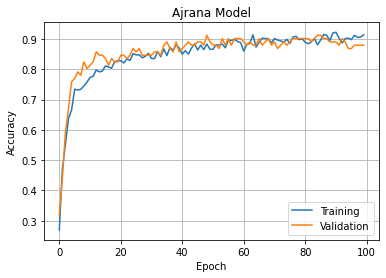

In [12]:
# plot accuracy
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.grid()
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Ajrana Model')
plt.savefig('ajrana_accuracy_sd.svg')

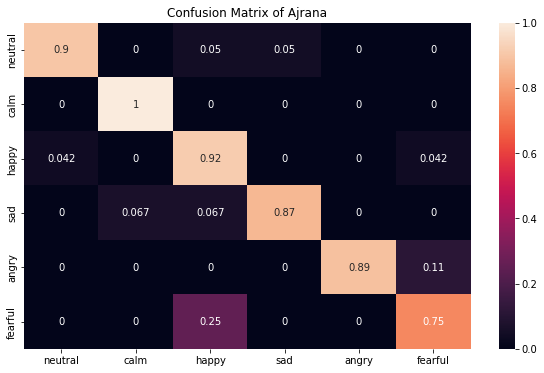

In [13]:
# make prediction for confusion_matrix
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
predict = model.predict(x_test, batch_size=16)
emotions=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful']

# predicted emotions from the test set
y_pred = np.argmax(predict, 1)
predicted_emo = []
for i in range(0,y_test.shape[0]):
    emo = emotions[y_pred[i]]
    predicted_emo.append(emo)

# get actual emotion
actual_emo = []
y_true = y_test
for i in range(0,y_test.shape[0]):
    emo = emotions[y_true[i]]
    actual_emo.append(emo)

# generate the confusion matrix
cm = confusion_matrix(actual_emo, predicted_emo)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful']
cm_df = pd.DataFrame(cm, index, columns)
plt.figure(figsize=(10, 6))
plt.title('Confusion Matrix of Ajrana')
sns.heatmap(cm_df, annot=True)
plt.savefig('ajrana_cm_sd.svg')

In [14]:
# print unweighted average recall
print("UAR: ", cm.trace()/cm.shape[0])

UAR:  0.887037037037037
